#### Import libraries

In [38]:
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
from skimage import io
from package import common
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#### Prepare data

In [39]:
# Read csv file
file_path = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/ThredupData.csv"
df = pd.read_csv(file_path)
# df.info() # hi it's bailey hi bailey <3 <3 Hi it's Karina!hi Karina

In [40]:
# categories = df['Category_Type'].unique()
# len_categories = len(categories)
# df['Category_Type'].value_counts()
# df.head()
# df['Description'][1000]

In [41]:
# df[['Category_Type']].value_counts()

##### filter images

In [42]:
# Remove images from the dataframe that are not present in the folder

# get images downloaded
downloaded_files = os.listdir("data/StanfordJpegs/")

# # apply labels to the dataset
df['filename'] = df['Item_Id'].apply(lambda x: 'item' + str(x))
df['is_downloaded'] = df['filename'].apply(lambda x: True if x in downloaded_files else False)

# check to see if it's applied
df['is_downloaded'].value_counts()

is_downloaded
True     5250
False       3
Name: count, dtype: int64

In [43]:
# determine the categories with more than 50 examples
cat_counts = df['Category_Type'].value_counts()
valid_cat = cat_counts[cat_counts>50].index.to_list()

# remove items that didn't get downloaded and lower value counts than 50
df_load = df[(df['is_downloaded'] == True) & (df['Category_Type'].isin(valid_cat))].copy()
# remove the replicated categories causal pants and khakis
df_load = df_load[~df_load['Category_Type'].isin(['Casual Pants', 'Khakis'])] 

# unique labels in the dataset
categories = df_load['Category_Type'].unique()
len_categories = len(categories)
print(f'the number of valid item categories: {len_categories}')

the number of valid item categories: 19


In [44]:
#create a mapping
cat_to_int = {item:idx for idx, item in enumerate(categories)}
int_to_cat = {idx:item for idx, item in enumerate(categories)}

df_load['labels'] = df_load['Category_Type'].apply(lambda x: cat_to_int[x])

# pull only filename and label
df_load = df_load[['filename','labels']]
df_load.head()

,filename,labels
0,item110746148,0
1,item111845154,0
2,item111894473,0
3,item111978980,0
4,item112127758,0


#####  create pytorch dataset.

In [45]:
# # create pytorch dataset.
def read_image(img_path):
    return Image.open(img_path).convert('RGB')

class ThredupDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def get_file(self,idx):
        label = self.img_labels.iloc[idx, 1]
        return os.path.join(self.img_dir, str(label), str(self.img_labels.iloc[idx, 0]))


    def __getitem__(self, idx):

        if isinstance(idx, slice):
        # Get the start, stop, and step from the slice
            return [self[ii] for ii in range(*idx.indices(len(self)))]
   
        
        label = self.img_labels.iloc[idx, 1]

        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]))
        image = read_image(img_path)
     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

##### Dataloader

In [46]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]) 

# Split the DataFrame into training and testing sets considering each label category
train_df, test_df = train_test_split(df_load, test_size=0.3, stratify=df_load['labels'], random_state=42)
# print(f'{len(train_df)=}, {len(test_df)=}')

train_data = ThredupDataset(
    img_labels=train_df,
    transform=transform,
    img_dir="data/StanfordJpegs/"
)

test_data = ThredupDataset(
    img_labels=test_df,
    transform=transform,
    img_dir="data/StanfordJpegs/"
)

In [47]:
# create data loader so images can be processed in batches.
trainloader = DataLoader(train_data, batch_size=64, shuffle=False)
testloader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(trainloader))

55


In [48]:
# # visualize the original image
# image, label = next(iter(trainloader))
# image.shape
# common.imshow(image[0,:])

In [49]:
# #visualize the normalized image
# to_pil = transforms.ToPILImage()
# to_pil(image[0,:])

In [96]:
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

for param in vgg.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(in_features, len_categories)  # change it to the number of classes in your task

for param in vgg.classifier.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.0003, weight_decay = 0.0001) # lr 0.003 to 0.03 # weight_decay = 0.0001


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [97]:
epochs = 4
ud=[]
import time
for e in range(epochs):
    start_time = time.time()
    vgg.train()
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Training pass
        optimizer.zero_grad()
        
        output = vgg(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            parameters = vgg.classifier.parameters()
            ud.append([((0.003*p.grad).std() / p.data.std()).log10().item() for p in parameters])
        
        running_loss += loss.item()
    end_time = time.time()
    print(f"Training loss: {running_loss/len(trainloader)}")
    print(f"epoch took {start_time-end_time}")

Training loss: 0.23247535490028728
epoch took -59.287418842315674
Training loss: 0.07479818384956823
epoch took -31.7833993434906
Training loss: 0.051124305867812254
epoch took -31.759084463119507
Training loss: 0.0455658940949599
epoch took -31.719695568084717


: 

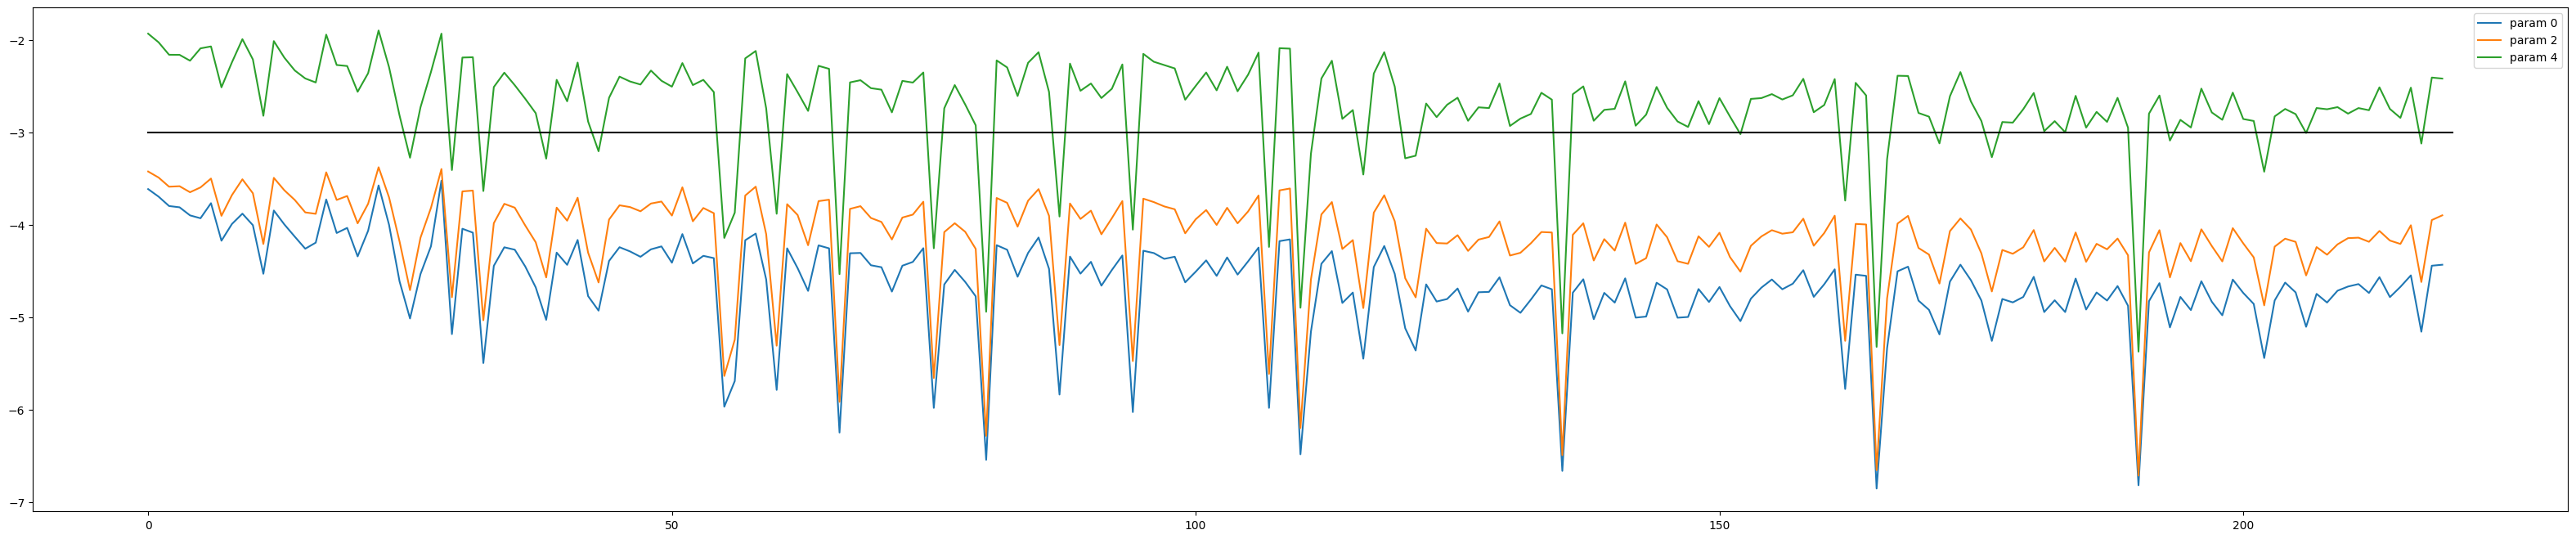

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 8))
legends = []
parameters=vgg.classifier.parameters()
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [53]:
# for p in vgg.classifier.parameters():
#     print(p.requires_grad)


In [93]:
#Save Weights or Load Saved Weights (optional)

#To save, uncomment below:
torch.save(vgg.state_dict(), 'savedParams.pt')

#To load saved weights, uncomment below:
#vgg = models.vgg19()
#vgg.load_state_dict(torch.load('savedParams.pt'))

In [55]:
def accuracy_vals(loader_name):
    vgg.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader_name:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
           

    accuracy = correct / total
    print(f"Accuracy on set: {accuracy * 100:.2f}%")

In [56]:
accuracy_vals(testloader)

Accuracy on set: 97.39%


In [57]:
accuracy_vals(trainloader)   #it was 94.55% with 4 eopchs and weight decay with only last layer trained

Accuracy on set: 98.20%


In [58]:
guess_mat=torch.zeros((len_categories, len_categories))
guess_mat2=torch.zeros((len_categories, len_categories))
with torch.no_grad():
    vgg.eval()
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        for i, j in zip(labels, predicted):
            guess_mat[i, j]+=1
        
       
        
        # img_inx=5
        # real_inx = labels[predicted != labels][img_inx].cpu()
        # predicted_inx = predicted[predicted != labels][img_inx].cpu()
        # print(f"real labels: {label_names[real_inx]}")
        # print(f"predicted labels: {label_names[predicted_inx]}")
        # common.imshow(inputs[predicted != labels][img_inx].cpu())

In [59]:
# common.imshow(inputs[labels == 17][0].cpu())
# common.imshow(inputs[labels == 18][1].cpu())
# common.imshow(inputs[labels == 19][1].cpu())

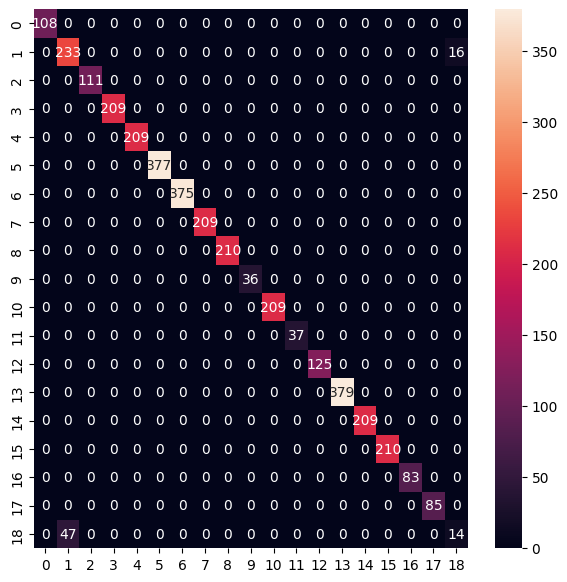

In [92]:
plt.figure(figsize=(7, 7))
sns.heatmap(guess_mat, annot=True, fmt='.0f')
plt.show()

In [76]:
false_pans = df_load[df_load['labels']==18]
false_data = ThredupDataset(
    img_labels=false_pans,
    transform=transform,
    img_dir="data/StanfordJpegs/"
)

falseloader = DataLoader(false_data, batch_size=64, shuffle=False)
# print(len(falseloader))

image, label = next(iter(falseloader))

In [94]:
# common.imshow(image[60,:])

In [66]:
int_to_cat

{0: 'Turtleneck Sweater',
 1: 'Beanie',
 2: 'Leather Crossbody Bag',
 3: 'Long Sleeve Button-Down Shirt',
 4: 'Ankle Boots',
 5: 'Jeans',
 6: 'Crossbody Bag',
 7: 'Short Sleeve T-Shirt',
 8: 'Sneakers',
 9: 'Baseball Cap',
 10: 'Long Sleeve Blouse',
 11: 'Clutch',
 12: 'Boots',
 13: 'Heels',
 14: 'Tank Top',
 15: 'Faux Leather Pants',
 16: 'Leather Satchel',
 17: 'Dress Pants',
 18: 'Sun Hat'}